## PLOT HEATMAPS AND DEATHS TREND

Script which containes the functions and information to Plot the Heatmaps and DeathsTrend of the simulated experiments.

In [5]:
# import relevant libraries
import pandas as pd
import numpy as np
np.seterr(divide='ignore', invalid='ignore') # ignore Warnings 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.MatplotlibDeprecationWarning)
import os
from itertools import product 
from datetime import date
import datetime
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True
plt.rcParams.update({"text.usetex": True,"font.family": "sans-serif","font.sans-serif": ["Helvetica"]})
from scipy.stats import sem
import scipy.stats as st
from sklearn.metrics import mean_squared_error

# Set base working directory
b_dir = "./Paramsweep/" # base directory -- extract the outputs of the simulations 
target_dir = "./Plots/Heatmaps_DeathsTrend_Plots/" # target directory -- store the final plots

### TABLE OF CONTENTS 
[1. Heatmap Plots](#heatmap)    
[1.1 Heatmap Functions](#heatmap_fn)    
[1.2 Heatmap Execution](#heatmap_ex)    
[2. DeathTrend Plots](#deathtrend)    
[2.1 DeathTrend Functions](#deathtrend_fn)    
[2.2 DeathTrend Execution](#deathtrend_ex)    

## 1.  Heatmap Plots 
<a id="heatmap"></a>

### 1.1  Heatmap Functions 
<a id="heatmap_fn"></a>

In [6]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    **Function** to set the heatmap design
    **Source**: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation='horizontal', ha="left",ma='left', position=(1,1.3),fontsize=30, labelpad=None)

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels, fontsize=34)
    ax.set_yticklabels(row_labels, fontsize=34)

    # Let the horizontal axes labeling appear on top.
    #ax.tick_params(top=True, bottom=False,
    #               labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None,**textkw):
    """
    A function to annotate a heatmap -- Source: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [27]:
def plot_heatmaps(country,p_infect_given_contact,month,d0,dmult_list,to_plot,\
                  d_lockdown,real_pop_size,n=10000000.0, save_plot=True, mse='MSE_STANDARD'):
    '''
    INPUTS:
    - country: string with the country name (e.g. 'Italy')
    - p_infect_given_contact: list with the simulation parameters for p_inf
    - d0: list with the simulation parameters for start date s0
    - dmult_list: list of values of simulation parameters for mortality multiplier parameters(e.g.[1,2])
    - n: int indicating the pop size (default = 10000000.0)
    - save_plot; default = True; indicate whether to save or not the final plot 
    - mse: argument to indicate whether the MSE should be computed from d0 or from another point in the simulation onwards; default= 'MSE_STANDARD' which computes the MSE on the whole simulation time-span
    
    OUTPUTS:
    - Best Combo Parameters; (pinf, d0, dmult)
    - Saves (if save_fig = True) the plot in the target directory
    '''
    num_combinations = len(list(product(d0,p_infect_given_contact)))
    n_dmult = len(dmult_list)
    best_combo_rmse = [] # store the best combo (rmse value of the selected best combination)
    best_combo_r0 = [] # store the R0 associated to the best parameters combination 
    best_combo_params = [] # store the best combo parameters 
    
    # set the COLORMAP range values; need to adapt the colormap for Germany 
    if country == "Germany":
        vmin = 0.9
        vmax = 1.8
        ticks = list(np.round(np.arange(0.9,1.8,0.1),3))
        cmap_name = "summer"
    else: 
        vmin = 0
        vmax = 15
        ticks = list(np.round(np.arange(0,15,2)))
        cmap_name = "summer"

    print(f'Plot Heatmaps for the parameters combination:')
    print(f'Country: {country}; Population Size: {n}; P_Infect_Given_Contact_List:{p_infect_given_contact}; Start Dates:{d0}; Mortality Multiplier Value:{dmult_list}')
    
    ## PLOT ##
    fig, ((ax,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(50,50))
    
    for dmult in dmult_list:
        mse_list = []
        r0_list = []
        month_list = []

        for p_inf in p_infect_given_contact: 
            for s in d0:
                month_index = d0.index(s)
                m = month[month_index] 
                # Get the MSE VALUES
                if mse == 'MSE_STANDARD':
                    filename_mse = "%s_n%s_p%s_m%s_s%s_mse.csv"  % (country,n,p_inf,dmult,s)
                    data_mse = pd.read_csv(os.path.join(b_dir,'%s/' %(country),filename_mse),header=None)
                    mse = data_mse.mean()[0]
                    mse_list.append(mse)
                    month_list.append(m)
                else: 
                    mse = compute_mse_lockdown(country,n,p_inf,dmult,m,s,d_lockdown,real_pop_size)
                    mse_list.append(mse)
                    month_list.append(m)

                # Get the R0 VALUES
                filename_r0 = "%s_n%s_p%s_m%s_s%s_r0_tot.csv" % (country,n,p_inf,dmult,s)
                data_r0 = pd.read_csv(os.path.join(b_dir,'%s/' %(country),filename_r0),header=None)
                r0 = data_r0.mean()[0]
                r0_list.append(r0)

        # TRANSFORM INTO AN ARRAY 
        a_rmse = np.array(np.sqrt(mse_list)) ### ROOT MEAN SQUARED ERROR 
        a_r0 = np.array(r0_list) ### RO VALUES 

        # RESHAPE
        a_rmse = a_rmse.reshape(len(p_infect_given_contact),len(d0))
        a_r0 = a_r0.reshape(len(p_infect_given_contact),len(d0))
        
        # RETRIEVE THE BEST COMBO
        rowmin = np.where(a_rmse == a_rmse.min())[0][0] # find the row position of the best (min) rmse
        colmin = np.where(a_rmse == a_rmse.min())[1][0] # find the col position of the best (min) rmse
        pinf_min = p_infect_given_contact[rowmin] # rietrieve the p_inf value associated to the best (min) rmse
        d0_min = d0[colmin] # retrieve the d0 value associated to the best (min) rmse
        month_min = month[colmin]
        best_combo_rmse.append(a_rmse[rowmin,colmin]) # store the best rmse value (per dmult)
        best_combo_r0.append(a_r0[rowmin,colmin]) # store the best r0 value associated 
        best_combo_params.append((dmult,pinf_min,d0_min,month_min)) # store the best parameters combination associated to the best rmse
        best_combo = best_combo_params[best_combo_rmse.index(min(best_combo_rmse))] # RETRIEVE THE BEST SIMULATION PARAMETERS

        # SET ROW AND COLUMNS NAME 
        colnames = d0 # columns names = start dates
        colnames2 = month
        colnames = [str(month[d0.index(x)]) + '/' + str(x) for x in colnames]
        rownames = p_infect_given_contact # rows names = p_infect_given_contact list
        rownames = ['{0:.3f}'.format(x) for x in rownames]
        #print(a_r0)
        #print(a_mse)

        goodness = a_rmse # MSE as GOODNESS measure to evaluate  
        if to_plot == 'R0':
            label_data = a_r0 # R0 is the data to display
        else: 
            label_data = a_rmse # TEST TEST TEST!! RMSE is the data to display
        
        ## PLOT 
        if dmult == dmult_list[0]:
            axins = inset_axes(ax,height="20%", width="75%", loc='upper right', bbox_to_anchor=(0.,1,1,0.085),
                               bbox_transform=ax.transAxes,borderpad=0,)
            # set the tick bar values 
            cb_kws = dict(cax = axins, norm=Normalize(vmin=vmin, vmax=vmax), ticks = ticks, orientation="horizontal")
            im, cbar = heatmap(goodness, rownames, colnames, ax=ax,
                                   cmap=cmap_name, cbarlabel=r'$RMSE$', clim = [vmin,vmax], cbar_kw = cb_kws)
            cbar.ax.tick_params(labelsize=32) 

            ##### ANNOTATE THE IMAGE 
            texts = annotate_heatmap(im,data = label_data,valfmt="{x:.3f}", threshold=800, size=33)
            # SET X AND Y LABELS 
            ax.set_ylabel(r'$p_{\mathrm{inf}}$', fontsize=54)
            ax.set_xlabel(r'$t_{\mathrm{0}}$', fontsize=53)
            ax.set_title(r'$d_{\mathrm{mult}} = %s$'%dmult, fontsize = 50,pad=15, loc='left')
            #fig.tight_layout()
            
        if dmult == dmult_list[1]:
            axins = inset_axes(ax2, height="20%", width="75%", loc='upper right',  bbox_to_anchor=(0.,1,1,0.085),
                               bbox_transform=ax2.transAxes,borderpad=0,)
            # set the tick bar values 
            cb_kws = dict(cax = axins, norm=Normalize(vmin=vmin, vmax=vmax), ticks = ticks, orientation="horizontal")
            ###### PLOT THE IMAGE
            im, cbar = heatmap(goodness, rownames, colnames, ax=ax2,
                                   cmap=cmap_name, cbarlabel=r'$RMSE$', clim = [vmin,vmax], cbar_kw = cb_kws)
            cbar.ax.tick_params(labelsize=32) 

            ##### ANNOTATE THE IMAGE 
            texts = annotate_heatmap(im, data = label_data, valfmt="{x:.3f}", threshold=800, size=33)
            # SET X AND Y LABELS 
            ax2.set_ylabel(r'$p_{\mathrm{inf}}$', fontsize=54)
            ax2.set_xlabel(r'$t_{\mathrm{0}}$', fontsize=53)
            ax2.set_title(r'$d_{\mathrm{mult}} = %s$'%dmult, fontsize = 50,pad=15, loc='left')
            #fig.tight_layout() 
            
        if dmult == dmult_list[2]:
            axins = inset_axes(ax3,height="20%", width="75%", loc='upper right',  bbox_to_anchor=(0.,1,1,0.085),
                               bbox_transform=ax3.transAxes,borderpad=0,)
            # set the tick bar values 
            cb_kws = dict(cax = axins, norm=Normalize(vmin=vmin, vmax=vmax), ticks = ticks, orientation="horizontal")
            ###### PLOT THE IMAGE
            im, cbar = heatmap(goodness, rownames, colnames, ax=ax3,
                                   cmap=cmap_name, cbarlabel=r'$RMSE$', clim = [vmin,vmax], cbar_kw = cb_kws)
            cbar.ax.tick_params(labelsize=32) 

            ##### ANNOTATE THE IMAGE 
            texts = annotate_heatmap(im, data = label_data, valfmt="{x:.3f}", threshold=800,size=33)
            # SET X AND Y LABELS 
            ax3.set_ylabel(r'$p_{\mathrm{inf}}$', fontsize=54)
            ax3.set_xlabel(r'$t_{\mathrm{0}}$', fontsize=53)
            ax3.set_title(r'$d_{\mathrm{mult}} = %s$'%dmult, fontsize = 50,pad=15, loc='left')
            #fig.tight_layout() 
            
        if dmult == dmult_list[3]:
            axins = inset_axes(ax4,height="20%", width="75%", loc='upper right',  bbox_to_anchor=(0.,1,1,0.085),
                               bbox_transform=ax4.transAxes,borderpad=0,)
            # set the tick bar values 
            cb_kws = dict(cax = axins, norm=Normalize(vmin=vmin, vmax=vmax), ticks = ticks, orientation="horizontal")
            ###### PLOT THE IMAGE
            im, cbar = heatmap(goodness, rownames, colnames, ax=ax4,
                                   cmap=cmap_name, cbarlabel=r'$RMSE$', clim = [vmin,vmax], cbar_kw = cb_kws)
            cbar.ax.tick_params(labelsize=32) 

            ##### ANNOTATE THE IMAGE 
            texts = annotate_heatmap(im, data = label_data, valfmt="{x:.3f}", threshold=800,size=33)
            # SET X AND Y LABELS 
            ax4.set_ylabel(r'$p_{\mathrm{inf}}$', fontsize=54)
            ax4.set_xlabel(r'$t_{\mathrm{0}}$', fontsize=53)
            ax4.set_title(r'$d_{\mathrm{mult}} = %s$'%dmult, fontsize = 50,pad=15, loc='left')
            #fig.tight_layout() 
    if save_plot == True:
        #plt.tight_layout()
        plt.savefig(os.path.join(target_dir,'Heatmap_{}.jpg'.format(country)),dpi=100)
        plt.show()
    else:
        plt.show()
    #print(f'The best combo for the parameters for {country} is:')
    #print(f'-Mortality Multiplier (dmult): {best_combo[0]}')
    #print(f'-Probability of Infection (pinf): {best_combo[1]}')
    #print(f'-Start Date (d0): {best_combo[2]}')
    #print(' ')
    #print(f'The RMSE for these parameters in a simulated population of {n} individuals is: {int(min(best_combo_rmse))}')
    #print(f'The R0 for these parameters in a simulated population of {n} individuals is: {round(best_combo_r0[best_combo_rmse.index(min(best_combo_rmse))],2)}')
    
    return(best_combo) # store the best combo (per d_mult value)

In [28]:
def read_combos(country):
    ''' INPUT:
        - country: a string representing the country of interest ('Italy','Spain','Germany','France')
        
        OUTPUT: 
        - p_infect_given_contact,d0,dmult_list: list of the parameters that were tested for that country'''
    if country == 'Italy':
        d0_list = [date(2020, 1, 3),date(2020, 1, 10),date(2020, 1, 17), date(2020, 1, 19),date(2020, 1, 21),date(2020, 1, 23),date(2020, 2, 6)]
        p_inf_list = [0.014,0.015,0.016,0.017,0.018,0.019,0.020,0.021,0.022,0.024]
        dmult_list = [0.8,1,2,3] 
        d_lockdown = date(2020, 3, 8)
        real_pop_size = 60000000
    elif country == 'Spain':
        d0_list = [date(2020, 1, 11),date(2020, 1, 18),date(2020, 1, 25), date(2020, 1, 27),date(2020, 1, 29),date(2020, 1, 31),date(2020, 2, 10)]
        p_inf_list = [0.016,0.017,0.018,0.019,0.020,0.021,0.022,0.024,0.026,0.028]
        dmult_list = [0.8,1,2,3] 
        d_lockdown = date(2020, 3, 14)
        real_pop_size = 47000000
    elif country == 'Germany':
        d0_list = [date(2020, 1, 7),date(2020, 1, 14),date(2020, 1, 21),date(2020, 1, 23),date(2020, 1, 25), date(2020, 1, 27),date(2020,2,10)]
        p_inf_list = [0.021,0.022,0.024,0.026,0.028,0.029,0.030,0.031,0.032,0.033]
        dmult_list = [0.8,1,2,3]
        d_lockdown = date(2020, 3, 13)
        real_pop_size = 80000000
    elif country == 'France':
        d0_list = [date(2020, 1, 4),date(2020, 1, 11),date(2020, 1, 18),date(2020, 1, 20),date(2020, 1, 22), date(2020, 1, 24),date(2020, 2, 7)]
        p_inf_list =[0.014,0.015,0.016,0.017,0.018,0.019,0.020,0.021,0.022,0.024]
        dmult_list = [0.8,1,2,3] 
        d_lockdown = date(2020, 3, 16)
        real_pop_size = 66000000
    p_infect_given_contact = p_inf_list
    month = [m.month for m in d0_list]
    s = [d.day for d in d0_list]
    dmult_list = [float(dmult) for dmult in dmult_list]
    return(p_infect_given_contact,month,s,d0_list,dmult_list,d_lockdown,real_pop_size)

In [29]:
def compute_mse_lockdown(country,n,p_inf,d_mult,m,s,d_lockdown,real_pop_size):
    '''
    Function to compute the MSE between the mean outcome across all simulation runs and the observed deaths data. 
    The MSE is computed starting from the date of the lockdown onwards which corresponds and covers the increasing part of the curve
    INPUT:
    - country (str): indicate the country of interest
    - n (float): indicate the population size
    - p_inf (float): indicate the probability of infection value 
    - d_mult (float): indicate the mortality multiplier value
    - m (int): month value related to the start date of infection (either 1:January or 2:February)
    - s (int): day value related to the start date of infection 
    - d_lockdown (date): date of the lockdown
    - real_pop_size (int): indicates the real population size of the country
    
    OUTCOME:
    - MSE: value of the computed MSE for the specific simulation 
    '''
    # Retrieve the DEATHS per time info
    filename_deaths = "%s_n%s_p%s_m%s_s%s_deaths.csv" % (country,n,p_inf,d_mult,s)
    data_deaths = pd.read_csv(os.path.join(b_dir,country,filename_deaths),header=None)
    data_deaths = (data_deaths/n)*100000 # simulated mortality rate / 100000 individuals 
    
    d0 = date(2020, m, s)
    data = pd.read_csv('validation_data/Experiments/%s_deaths.csv' %country) # read validation dataset
    d_lockdown = str(d_lockdown) # transform the data in a string 
    lb = data[data['Date'] == d_lockdown].index[0]
    dates = [] 
    actual_deaths = []
    for i in range(lb,len(data)):
        dates.append(pd.to_datetime(data['Date'][i],format='%Y-%m-%d').date()) # append the deaths date
        #actual_deaths.append(((data['Deaths'][i])*n)/real_pop_size) # append the deaths scaled by n 
        actual_deaths.append(((data['Deaths'][i])/real_pop_size)*100000) # real mortality rate / 100k people
    
    time_from_d0 = []
    for i in range(len(dates)):
        time_from_d0.append((dates[i] - d0).days)
    f = time_from_d0[0] 
    l = time_from_d0[-1] + 1
    
    mse = mean_squared_error(data_deaths.loc[:,f:l].mean(axis=0),actual_deaths) # MSE evaluated on mortality rate / 100k individuals 
    mse_list = float(mse)
    return(mse)

### 1.2  Heatmap Execution
<a id="heatmap_ex"></a>

#### Italy

Plot Heatmaps for the parameters combination:
Country: Italy; Population Size: 500000.0; P_Infect_Given_Contact_List:[0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02, 0.021, 0.022, 0.024]; Start Dates:[3, 10, 17, 19, 21, 23, 6]; Mortality Multiplier Value:[0.8, 1.0, 2.0, 3.0]


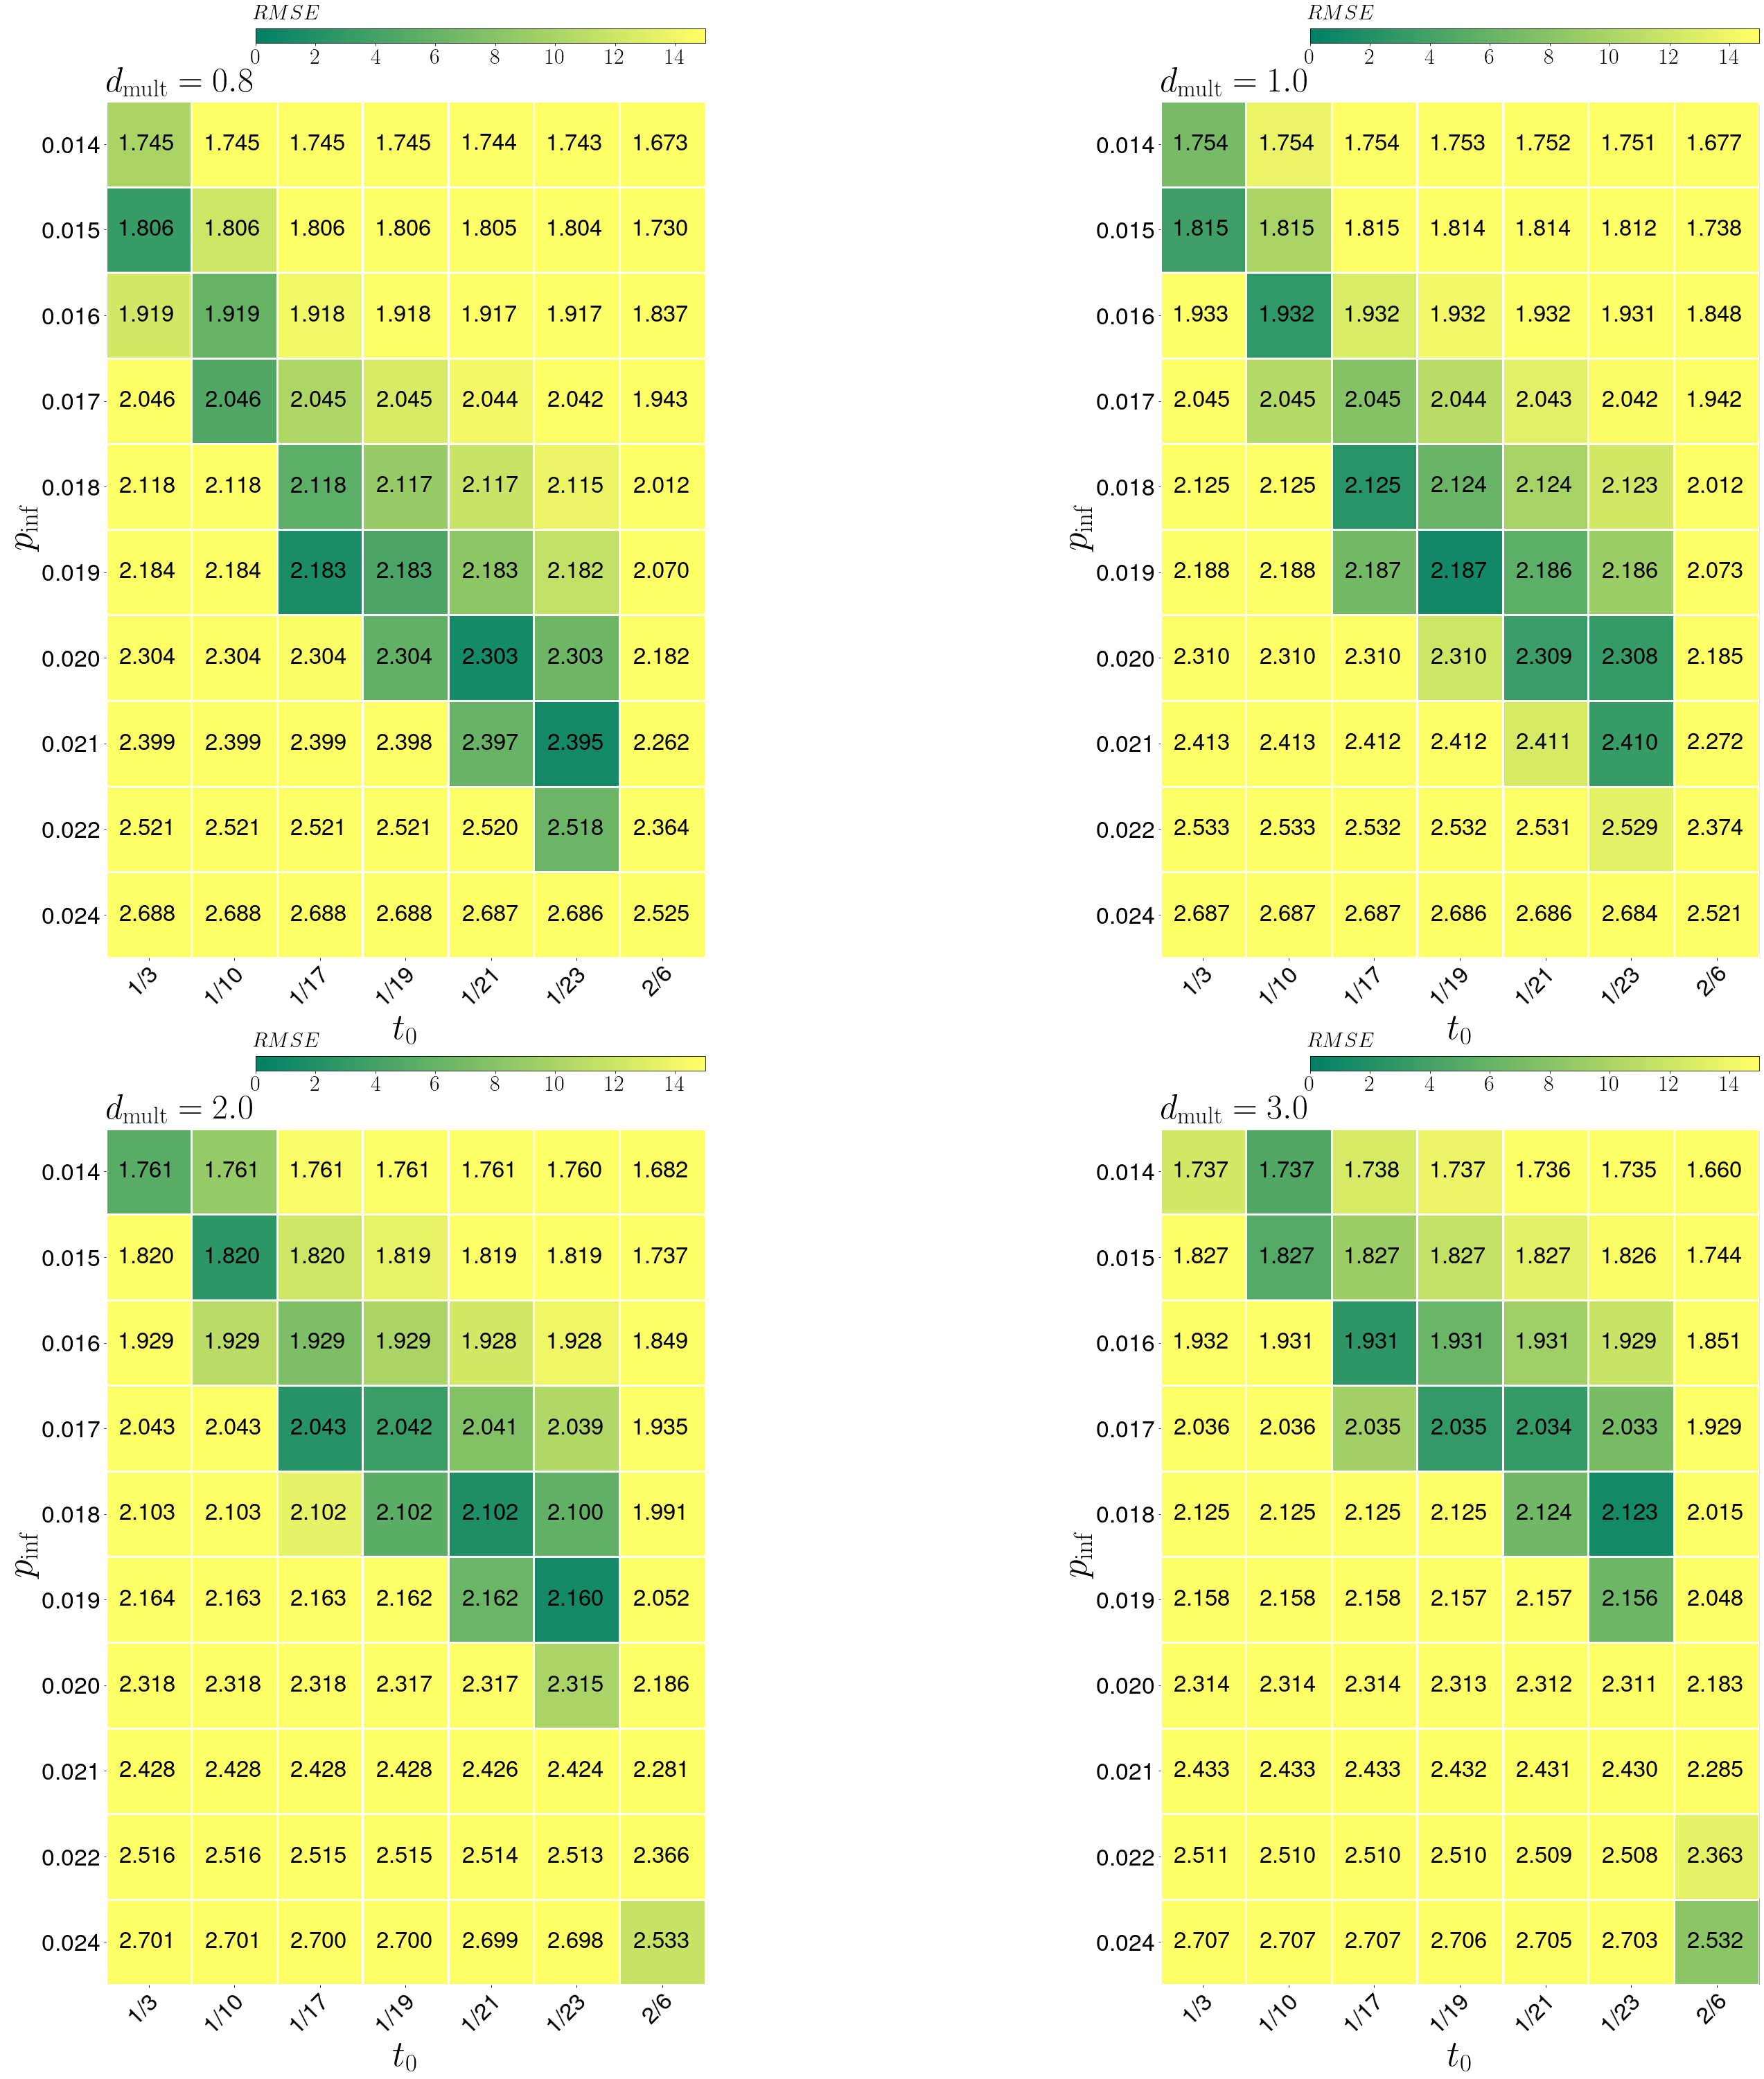

(1.0, 0.019, 19, 1)

In [30]:
#### PLOT HEATMAP FOR EXPERIMENT PARAMETERS -- ITALY 
# Experiment Parameters; Display R0 as label data 
country = 'Italy' 
n = 500000.0
save_plot = True
to_plot = 'R0'
mse='MSE_Lockdown'

p_infect_given_contact,month,d0,d0_list,dmult_list,d_lockdown,real_pop_size=read_combos(country)
best_combo_italy = plot_heatmaps(country,p_infect_given_contact,month,d0,dmult_list,to_plot, \
                                 d_lockdown,real_pop_size,n,save_plot, mse)
best_combo_italy

#### Spain

Plot Heatmaps for the parameters combination:
Country: Spain; Population Size: 500000.0; P_Infect_Given_Contact_List:[0.016, 0.017, 0.018, 0.019, 0.02, 0.021, 0.022, 0.024, 0.026, 0.028]; Start Dates:[11, 18, 25, 27, 29, 31, 10]; Mortality Multiplier Value:[0.8, 1.0, 2.0, 3.0]


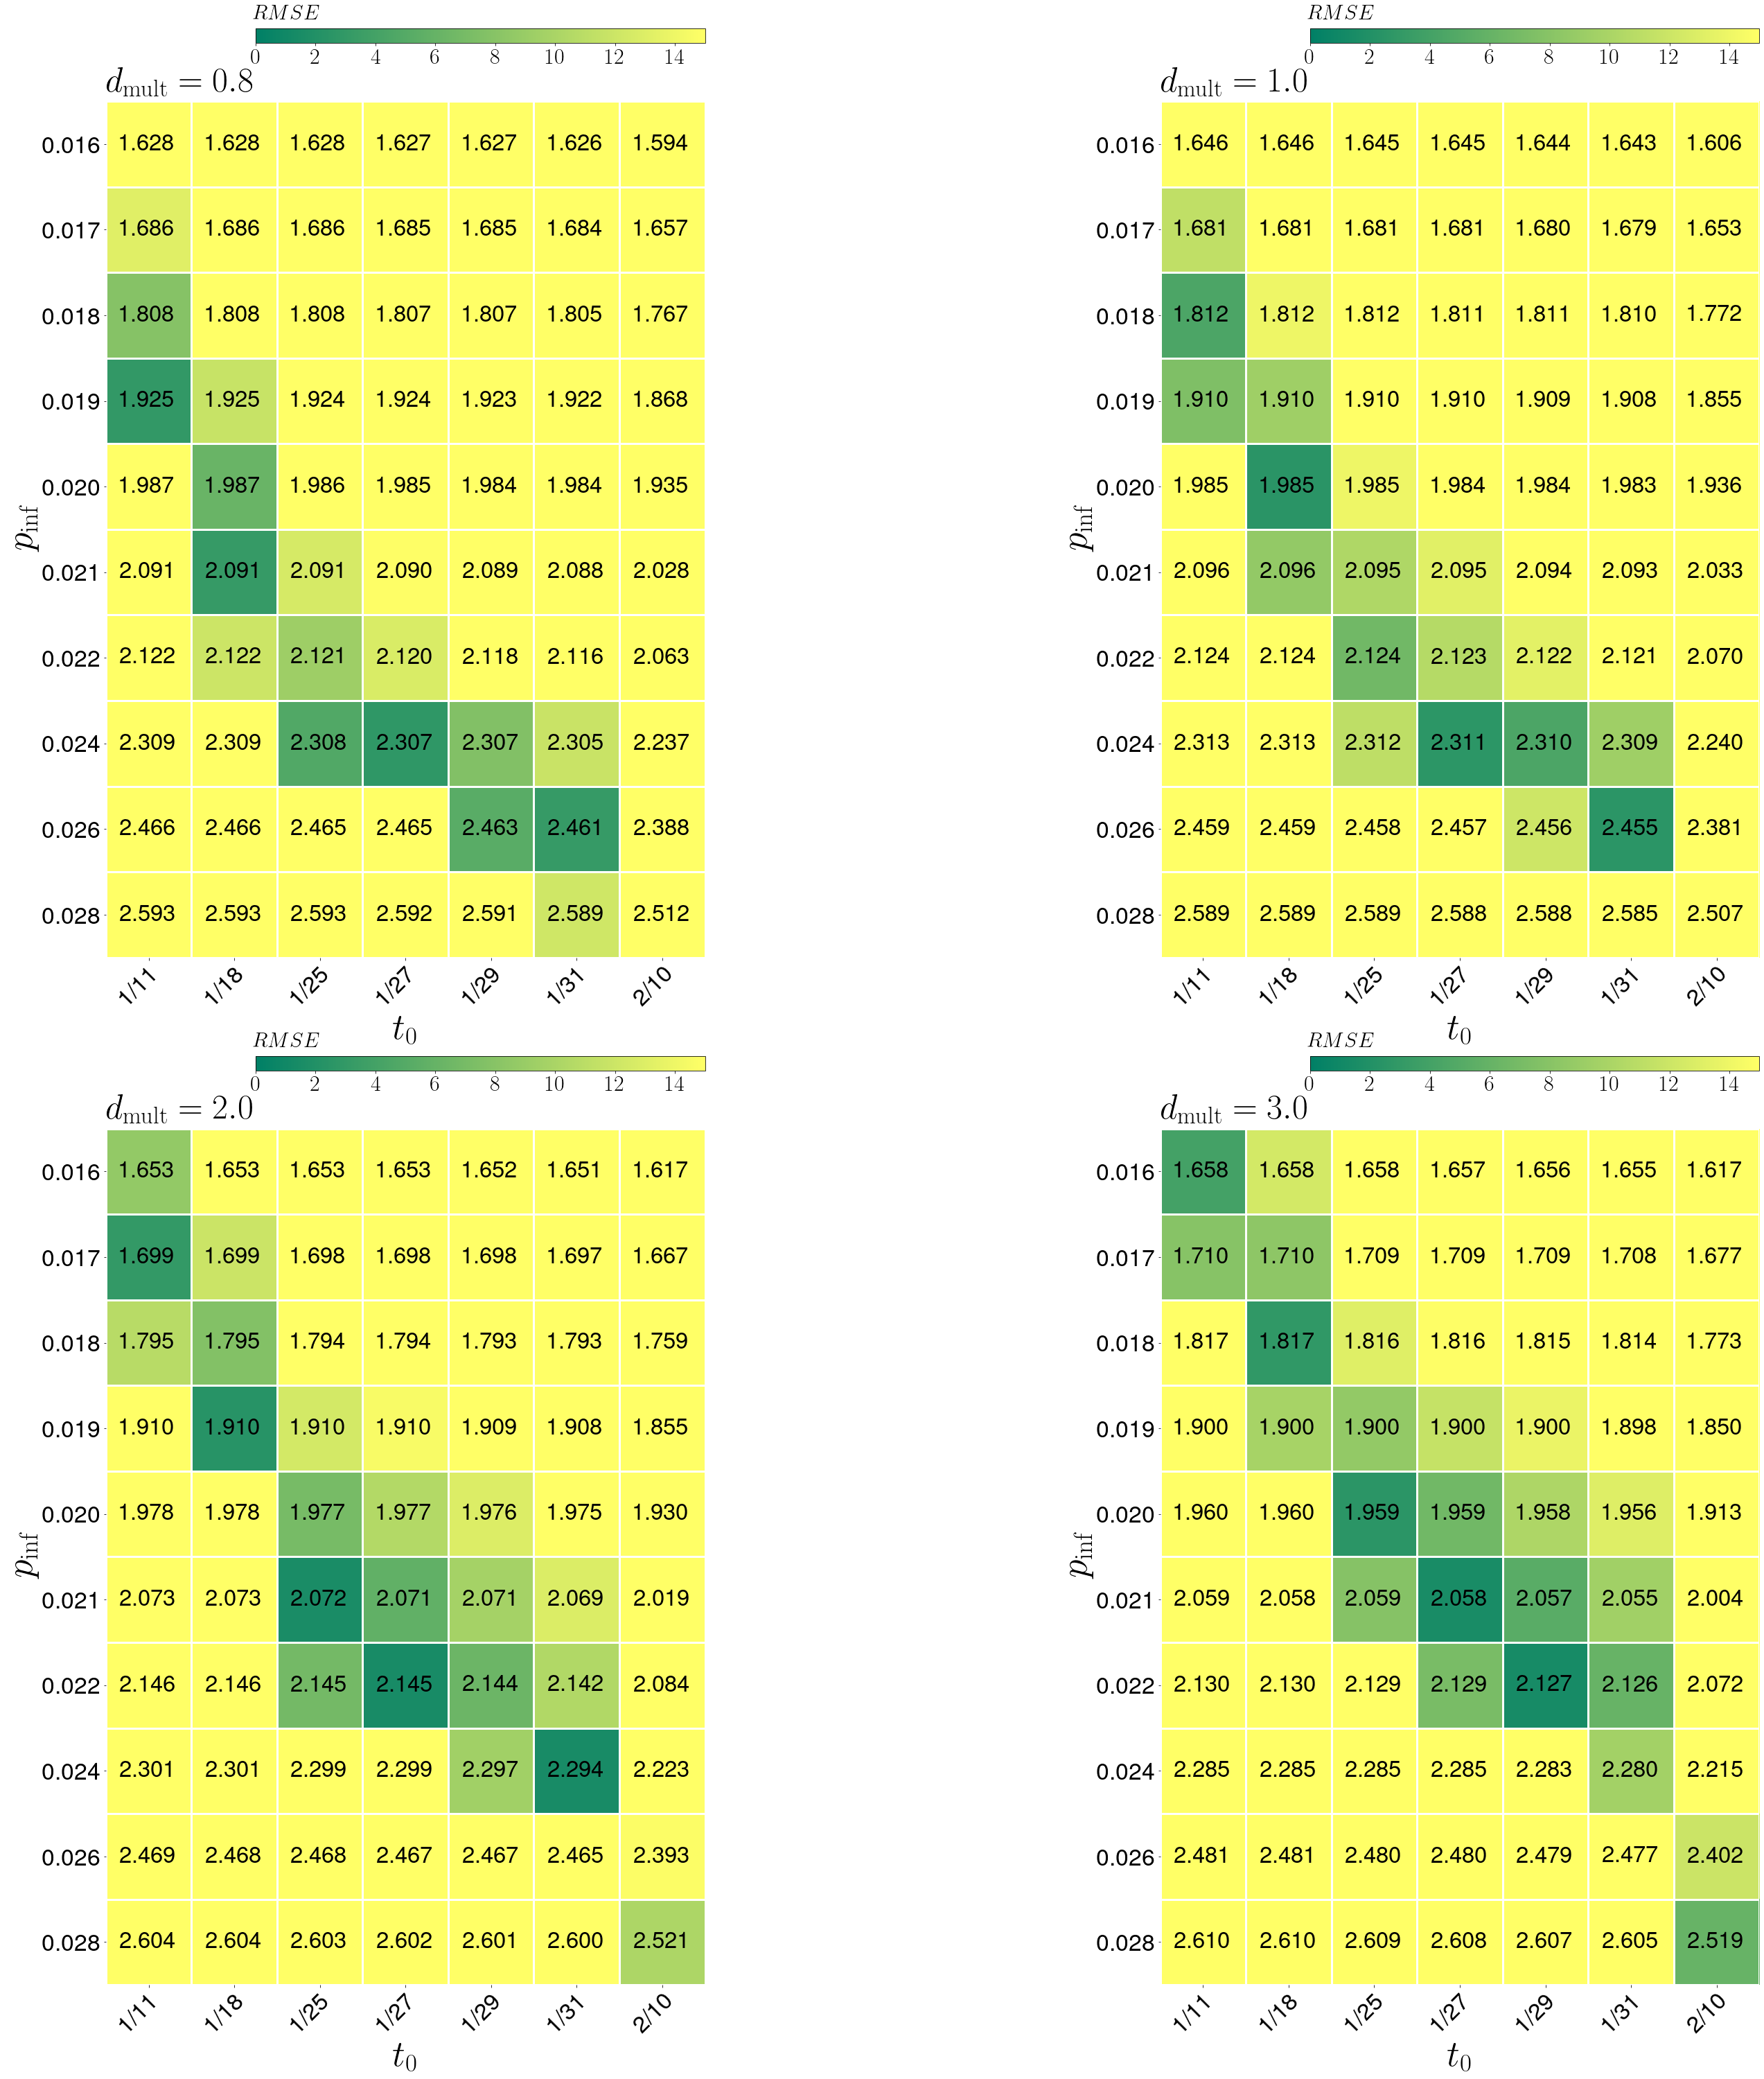

(3.0, 0.022, 29, 1)

In [31]:
#### PLOT HEATMAP FOR EXPERIMENT PARAMETERS -- SPAIN 
# Experiment Parameters; Display R0 as label data 
country = 'Spain' 
n = 500000.0
save_plot = True
to_plot = 'R0'
mse='MSE_Lockdown'

p_infect_given_contact,month,d0,d0_list,dmult_list,d_lockdown,real_pop_size=read_combos(country)
best_combo_spain = plot_heatmaps(country,p_infect_given_contact,month,d0,dmult_list,to_plot, \
                                 d_lockdown,real_pop_size,n,save_plot, mse)
best_combo_spain

#### Germany

Plot Heatmaps for the parameters combination:
Country: Germany; Population Size: 500000.0; P_Infect_Given_Contact_List:[0.021, 0.022, 0.024, 0.026, 0.028, 0.029, 0.03, 0.031, 0.032, 0.033]; Start Dates:[7, 14, 21, 23, 25, 27, 10]; Mortality Multiplier Value:[0.8, 1.0, 2.0, 3.0]


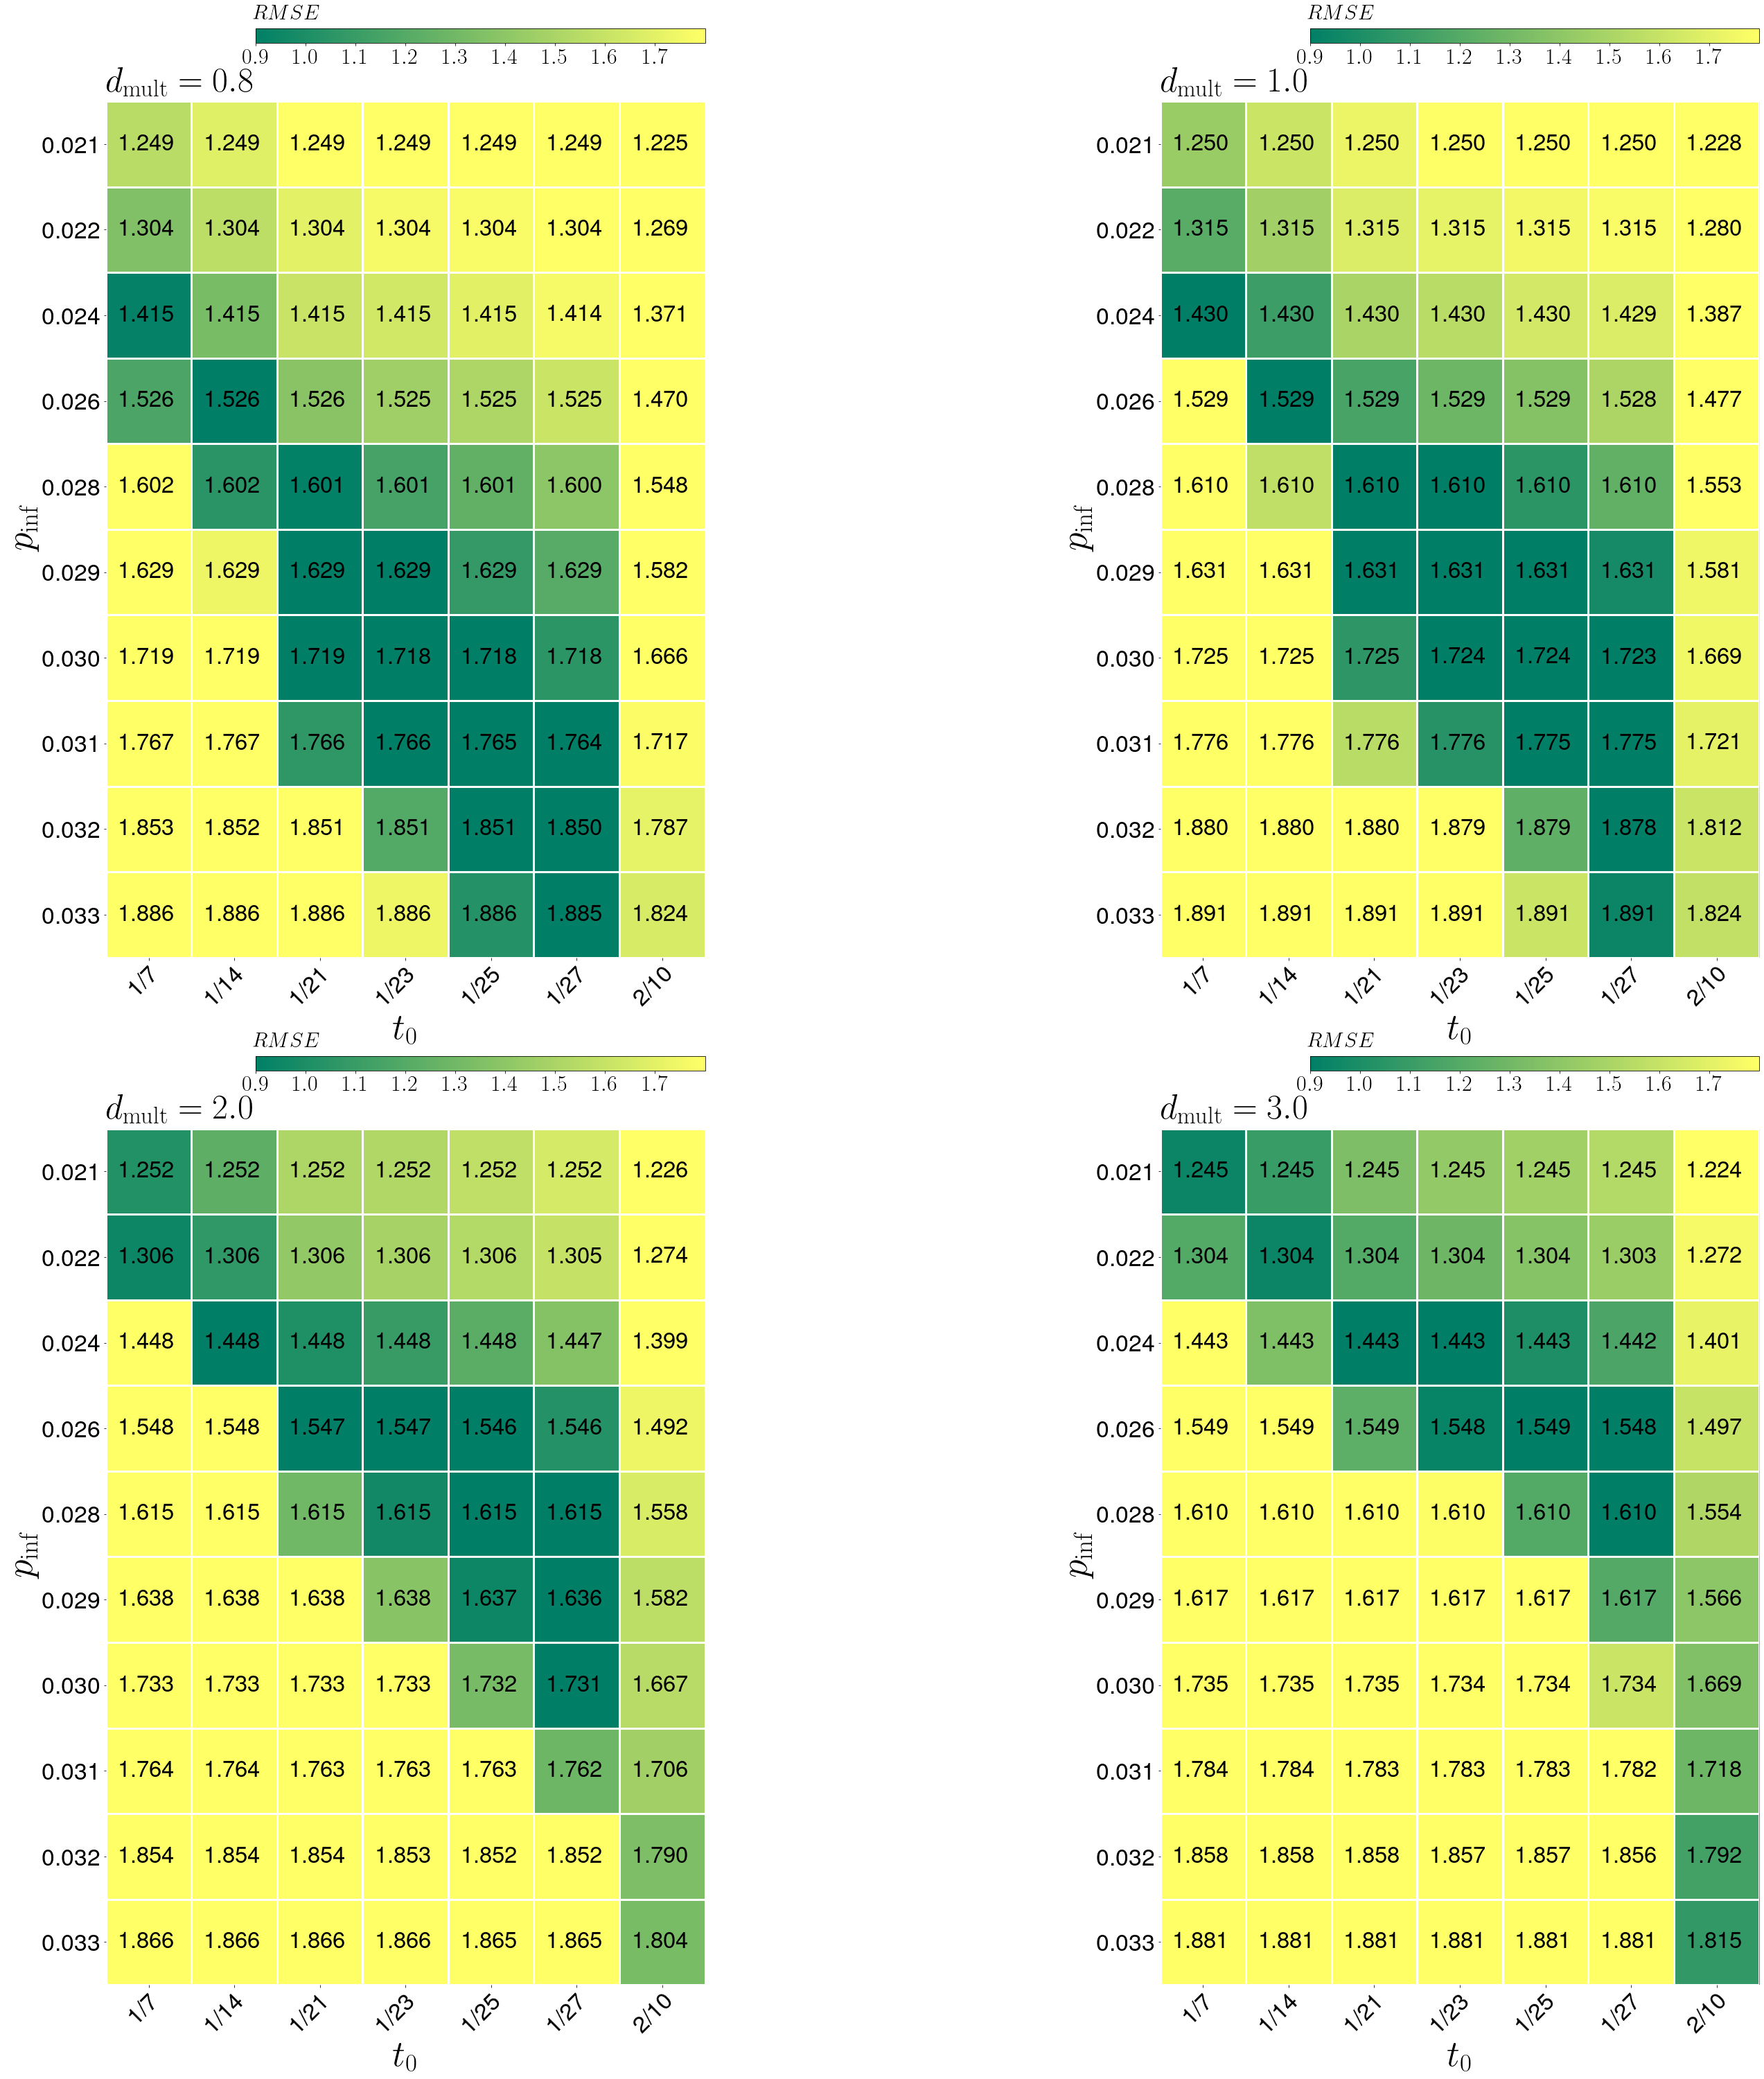

(0.8, 0.031, 25, 1)

In [32]:
#### PLOT HEATMAP FOR EXPERIMENT PARAMETERS -- GERMANY
# Experiment Parameters; Display R0 as label data 
country = 'Germany' 
n = 500000.0
save_plot = True
to_plot = 'R0'
mse='MSE_Lockdown'

p_infect_given_contact,month,d0,d0_list,dmult_list,d_lockdown,real_pop_size=read_combos(country)
best_combo_germany = plot_heatmaps(country,p_infect_given_contact,month,d0,dmult_list,to_plot, \
                                 d_lockdown,real_pop_size,n,save_plot, mse)
best_combo_germany

#### France

Plot Heatmaps for the parameters combination:
Country: France; Population Size: 500000.0; P_Infect_Given_Contact_List:[0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02, 0.021, 0.022, 0.024]; Start Dates:[4, 11, 18, 20, 22, 24, 7]; Mortality Multiplier Value:[0.8, 1.0, 2.0, 3.0]


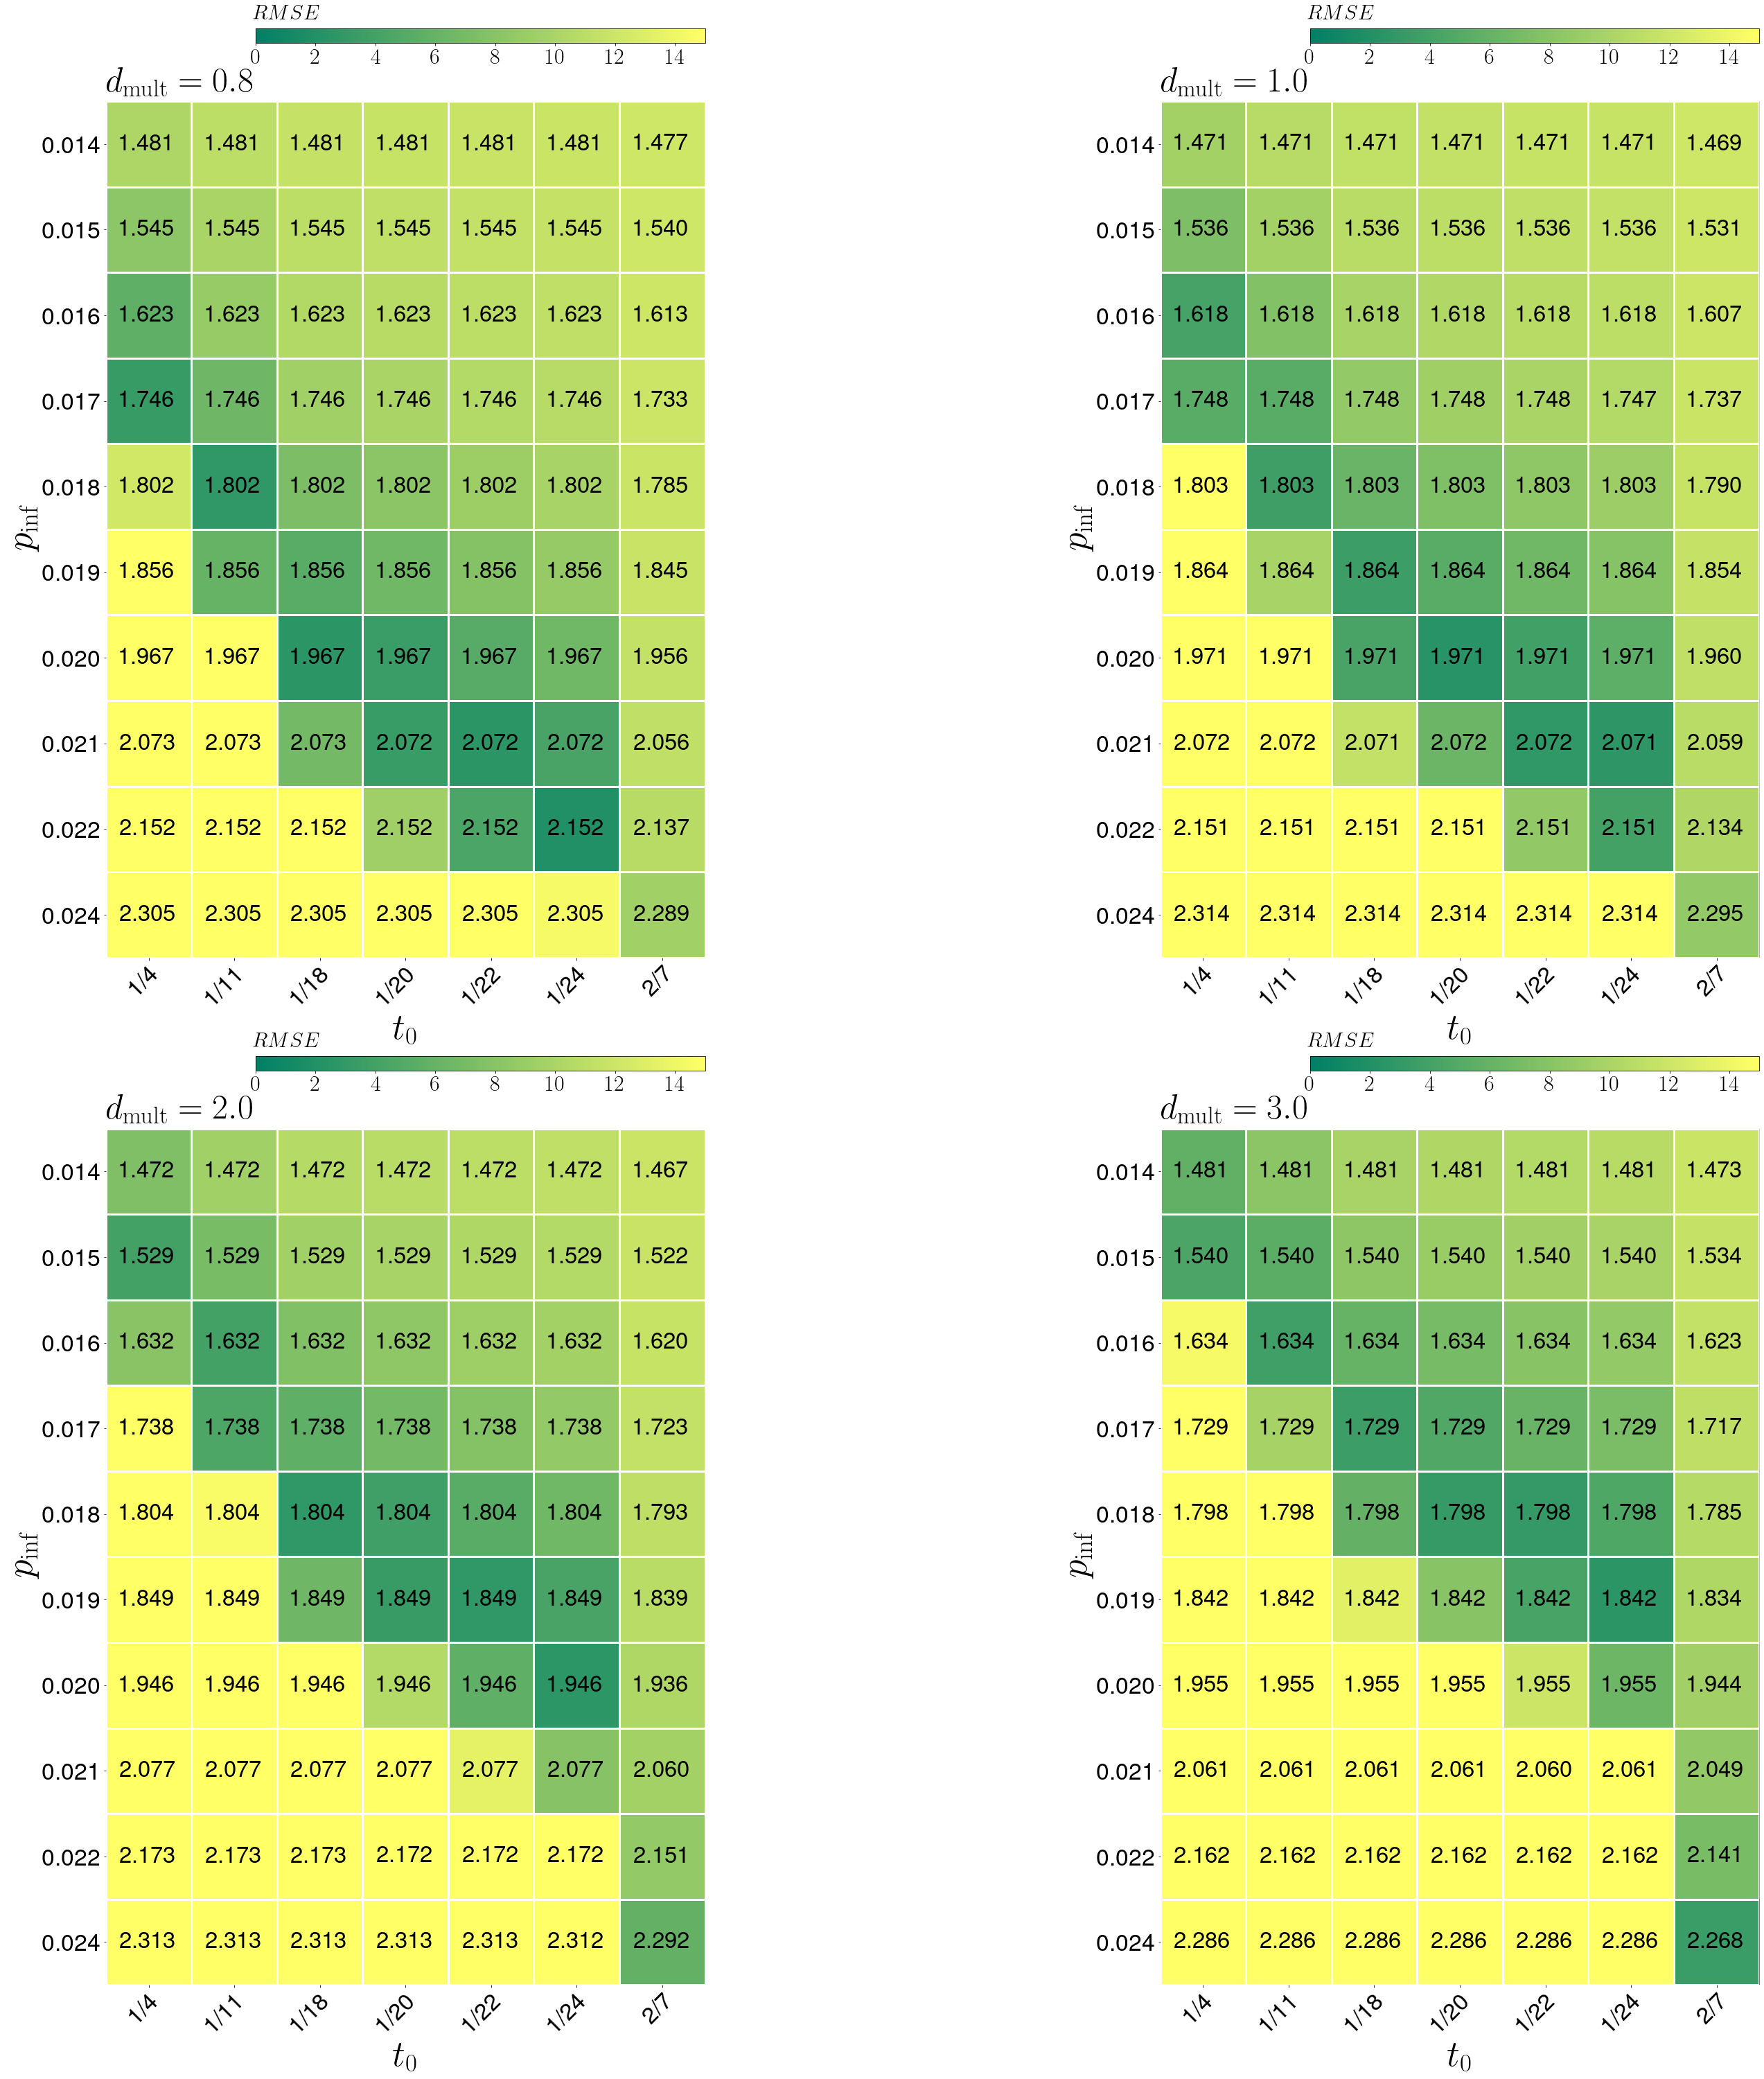

(0.8, 0.022, 24, 1)

In [33]:
#### PLOT HEATMAP FOR EXPERIMENT PARAMETERS -- FRANCE 
# Experiment Parameters; Display R0 as label data 
country = 'France' 
n = 500000.0
save_plot = True
to_plot = 'R0'
mse='MSE_Lockdown'

p_infect_given_contact,month,d0,d0_list,dmult_list,d_lockdown,real_pop_size=read_combos(country)
best_combo_france = plot_heatmaps(country,p_infect_given_contact,month,d0,dmult_list,to_plot, \
                                 d_lockdown,real_pop_size,n,save_plot, mse)
best_combo_france

## 2.  DeathTrend Plots 
<a id="deathtrend"></a>

### 2.1  DeathTrends Functions
<a id="deathtrend_fn"></a>

In [10]:
#### PLOT DEATHS TRAJECTORIES
def plot_deathstrend(country,n,best_combo,save_plot = True):
    '''
    Function to plot the simulated Death Trend vs the Observed Death Trend of a given country given the Best Parameter Combination
    INPUTS:
    - country: string with the country name (e.g. 'Italy')
    - n: int indicating the pop size (default = 10000000.0)
    - save_plot; default = True; indicate whether to save or not the final plot 
    - best_combo: tuple of length 3 composed of (dmult,pinf,d0)
    OUTPUTS: 
    - plt.show() the validation results
    - Saves (if save_plot = True) the final plot into the target directory
    '''
    # INITIALIZATION 
    if country == 'Italy':
        d_lockdown = date(2020, 3, 8) # lockdown
        real_pop_size = 60000000
        target_p = best_combo[1]
        target_mult = best_combo[0]
        target_start = best_combo[2]
        month = best_combo[3]
    elif country == 'Spain':
        d_lockdown = date(2020, 3, 14) 
        real_pop_size = 47000000
        target_p = best_combo[1]
        target_mult = best_combo[0]
        target_start = best_combo[2]
        month = best_combo[3]
    elif country == 'Germany':
        d_lockdown = date(2020, 3, 13)
        real_pop_size = 80000000
        target_p = best_combo[1]
        target_mult = best_combo[0]
        target_start = best_combo[2]
        month = best_combo[3]
    elif country == 'France':
        d_lockdown = date(2020, 3, 16)
        real_pop_size = 66000000
        target_p = best_combo[1]
        target_mult = best_combo[0]
        target_start = best_combo[2]
        month = best_combo[3]
    
    d0 = date(2020, month, target_start) # simulation start date
    d_end = date(2020, 4, 15) # simulation stop date
    t_lockdown = (d_lockdown - d0).days # time from the lockdown date wrt to the start 
    
    # retrieve validation data 
    data = pd.read_csv('validation_data/Experiments/%s_deaths.csv' %(country))
    dates = []
    deaths = []
    for i in range(len(data)):
        dates.append(pd.to_datetime(data['Date'][i],format='%Y-%m-%d').date())
        #deaths.append(((data['Deaths'][i])*n)/real_pop_size) # scale down the real death to a 10millions population 
        #deaths.append((data['Deaths'][i])) # real number of deaths
        deaths.append(((data['Deaths'][i])/real_pop_size)*100000) # mortality rate / 100000 individuals 
        
    filename_deaths = "%s_n%s_p%s_m%s_s%s_deaths.csv" % (country,n,target_p,target_mult,target_start)
    data_deaths = pd.read_csv(os.path.join(b_dir,country,filename_deaths),header=None)
    #deaths_target_date = (data_deaths*real_pop_size)/n # re-scale the deaths trend to the real pop size and data 
    deaths_target_date = (data_deaths/n)*100000 # simulated mortality rate / 100000 individuals 
    
    # set the lockdown start date
    t_lockdown_start = float((d_lockdown - d0).days)
    deaths_target_date = deaths_target_date.to_numpy()
    time_from_d0 = []
    for i in range(len(dates)):
        time_from_d0.append((dates[i] - d0).days)

    ### PLOT DEATHS TRAJECTORY FIGURE 
    matplotlib.rcParams['ps.useafm'] = True
    matplotlib.rcParams['pdf.use14corefonts'] = True
    matplotlib.rcParams['text.usetex'] = True
    plt.rcParams.update({"text.usetex": True,"font.family": "sans-serif","font.sans-serif": ["Helvetica"]})
    plt.figure(figsize=(10,6))

    # plot all the simulations results 
    for i in range(deaths_target_date.shape[0]):
        plt.plot(deaths_target_date[i], alpha = 0.08, c='C0')
    # plot the real observed deaths values 
    plt.scatter(time_from_d0, deaths, color='k', s=10)
    # plot the median of all the simulations 
    plt.plot(np.mean(deaths_target_date, axis=0), color = 'g', lw = 2.5)
    # confidence interval (90%)
    ci = st.sem(deaths_target_date, axis=0)
    #ci = st.t.interval(0.90, deaths_target_date.shape[1]-1, loc=np.nan_to_num(np.mean(deaths_target_date,axis=0)), scale=np.nan_to_num(st.sem(deaths_target_date,axis=0)))
    plt.fill_between(range(0,deaths_target_date.shape[1]), deaths_target_date.mean(axis=0)-2*ci, deaths_target_date.mean(axis=0)+2*ci, color='green', alpha=0.2)
    # plot vertical line corresponding to lockdown date
    plt.vlines(t_lockdown_start, 0, 1.5*deaths_target_date[:, -1].max(), linestyles = '--', color='r', alpha = 0.2)
    plt.ylim(0,1.05*deaths_target_date[:, -1].max()) # set ylim
    plt.xlim(0,deaths_target_date.shape[1]-1) # set xlim 
    plt.ylabel("Total Deaths \n (per 100k individuals)", fontsize=13) 
    plt.xlabel("Date", fontsize=13)
    plt.title(f"Simulation Validation for {country}", fontsize = 15)

    date_labels = []
    for i in range(deaths_target_date.shape[1]):
        new_date = d0 + datetime.timedelta(days=i)
        date_labels.append(r'${}/{}$'.format(new_date.month, new_date.day))
    plt.tick_params(axis='both', which='major', labelsize=15)
    currticks = plt.xticks()
    currticks = [int(i) for i in currticks[0] if i >= 0 and i < deaths_target_date.shape[1]]
    plt.xticks(currticks)
    plt.xticks(currticks, [date_labels[i] for i in currticks], rotation=45)
    if country == 'Germany':
        step = 2
    else: 
        step = 10
    plt.yticks(np.arange(0,1.05*deaths_target_date[:, -1].max(), step=step)) 
    
    # SAVE RESULTS AND/OR SHOW THE PLOT
    if save_plot == True:
        plt.tight_layout()
        plt.savefig(os.path.join(target_dir,'Deaths_Trend_{}.jpg'.format(country)),dpi=100)
        plt.show()
    else:
        plt.show()

### 2.2  DeathTrends Execution
<a id="deathtrend_ex"></a>

### ITALY 

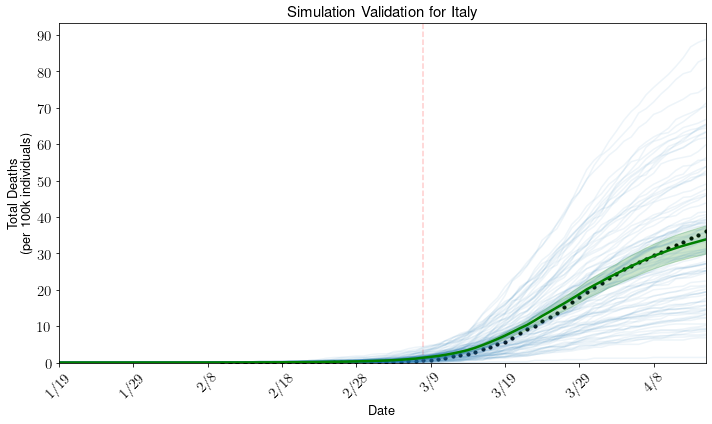

In [11]:
deaths_trend_ita = plot_deathstrend('Italy',500000.0,best_combo_italy,save_plot = True)

### SPAIN

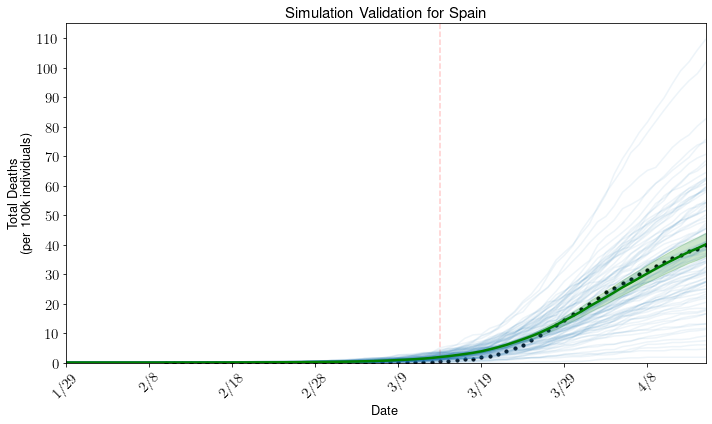

In [12]:
deaths_trend_spa = plot_deathstrend('Spain',500000.0,best_combo_spain,save_plot = True)

### GERMANY 

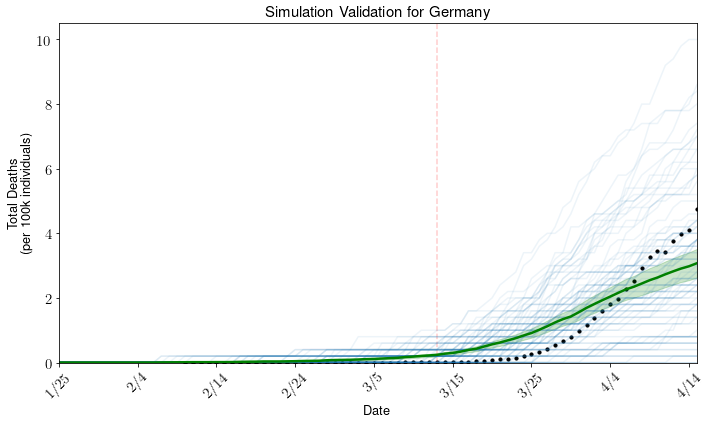

In [13]:
### BEST COMBO FOR FRANCE RESULTING FROM MSE SEARCH 
deaths_trend_ger = plot_deathstrend('Germany',500000.0,best_combo_germany,save_plot = True)

### FRANCE 

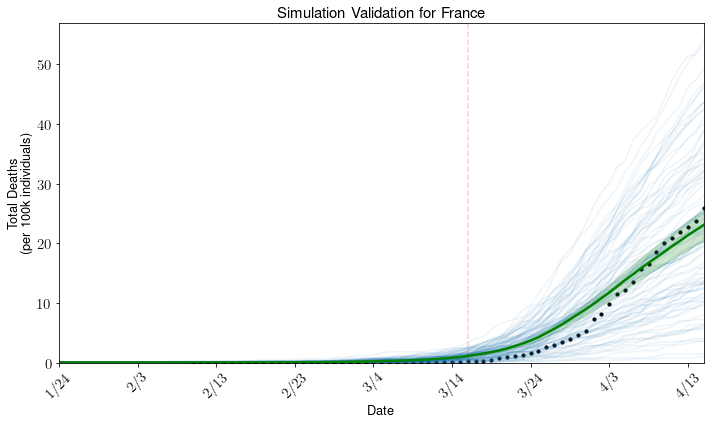

In [14]:
### BEST COMBO FOR FRANCE RESULTING FROM MSE SEARCH 
deaths_trend_fra = plot_deathstrend('France',500000.0,best_combo_france,save_plot = True)